# Modern AI Development Pipeline using Docker, GPU, Jupyter and VS Code

In [2]:
import datetime 
print('2019-10-01')
print(str(datetime.datetime.now().isoformat()))

2019-10-01
2019-10-02T04:25:07.393839


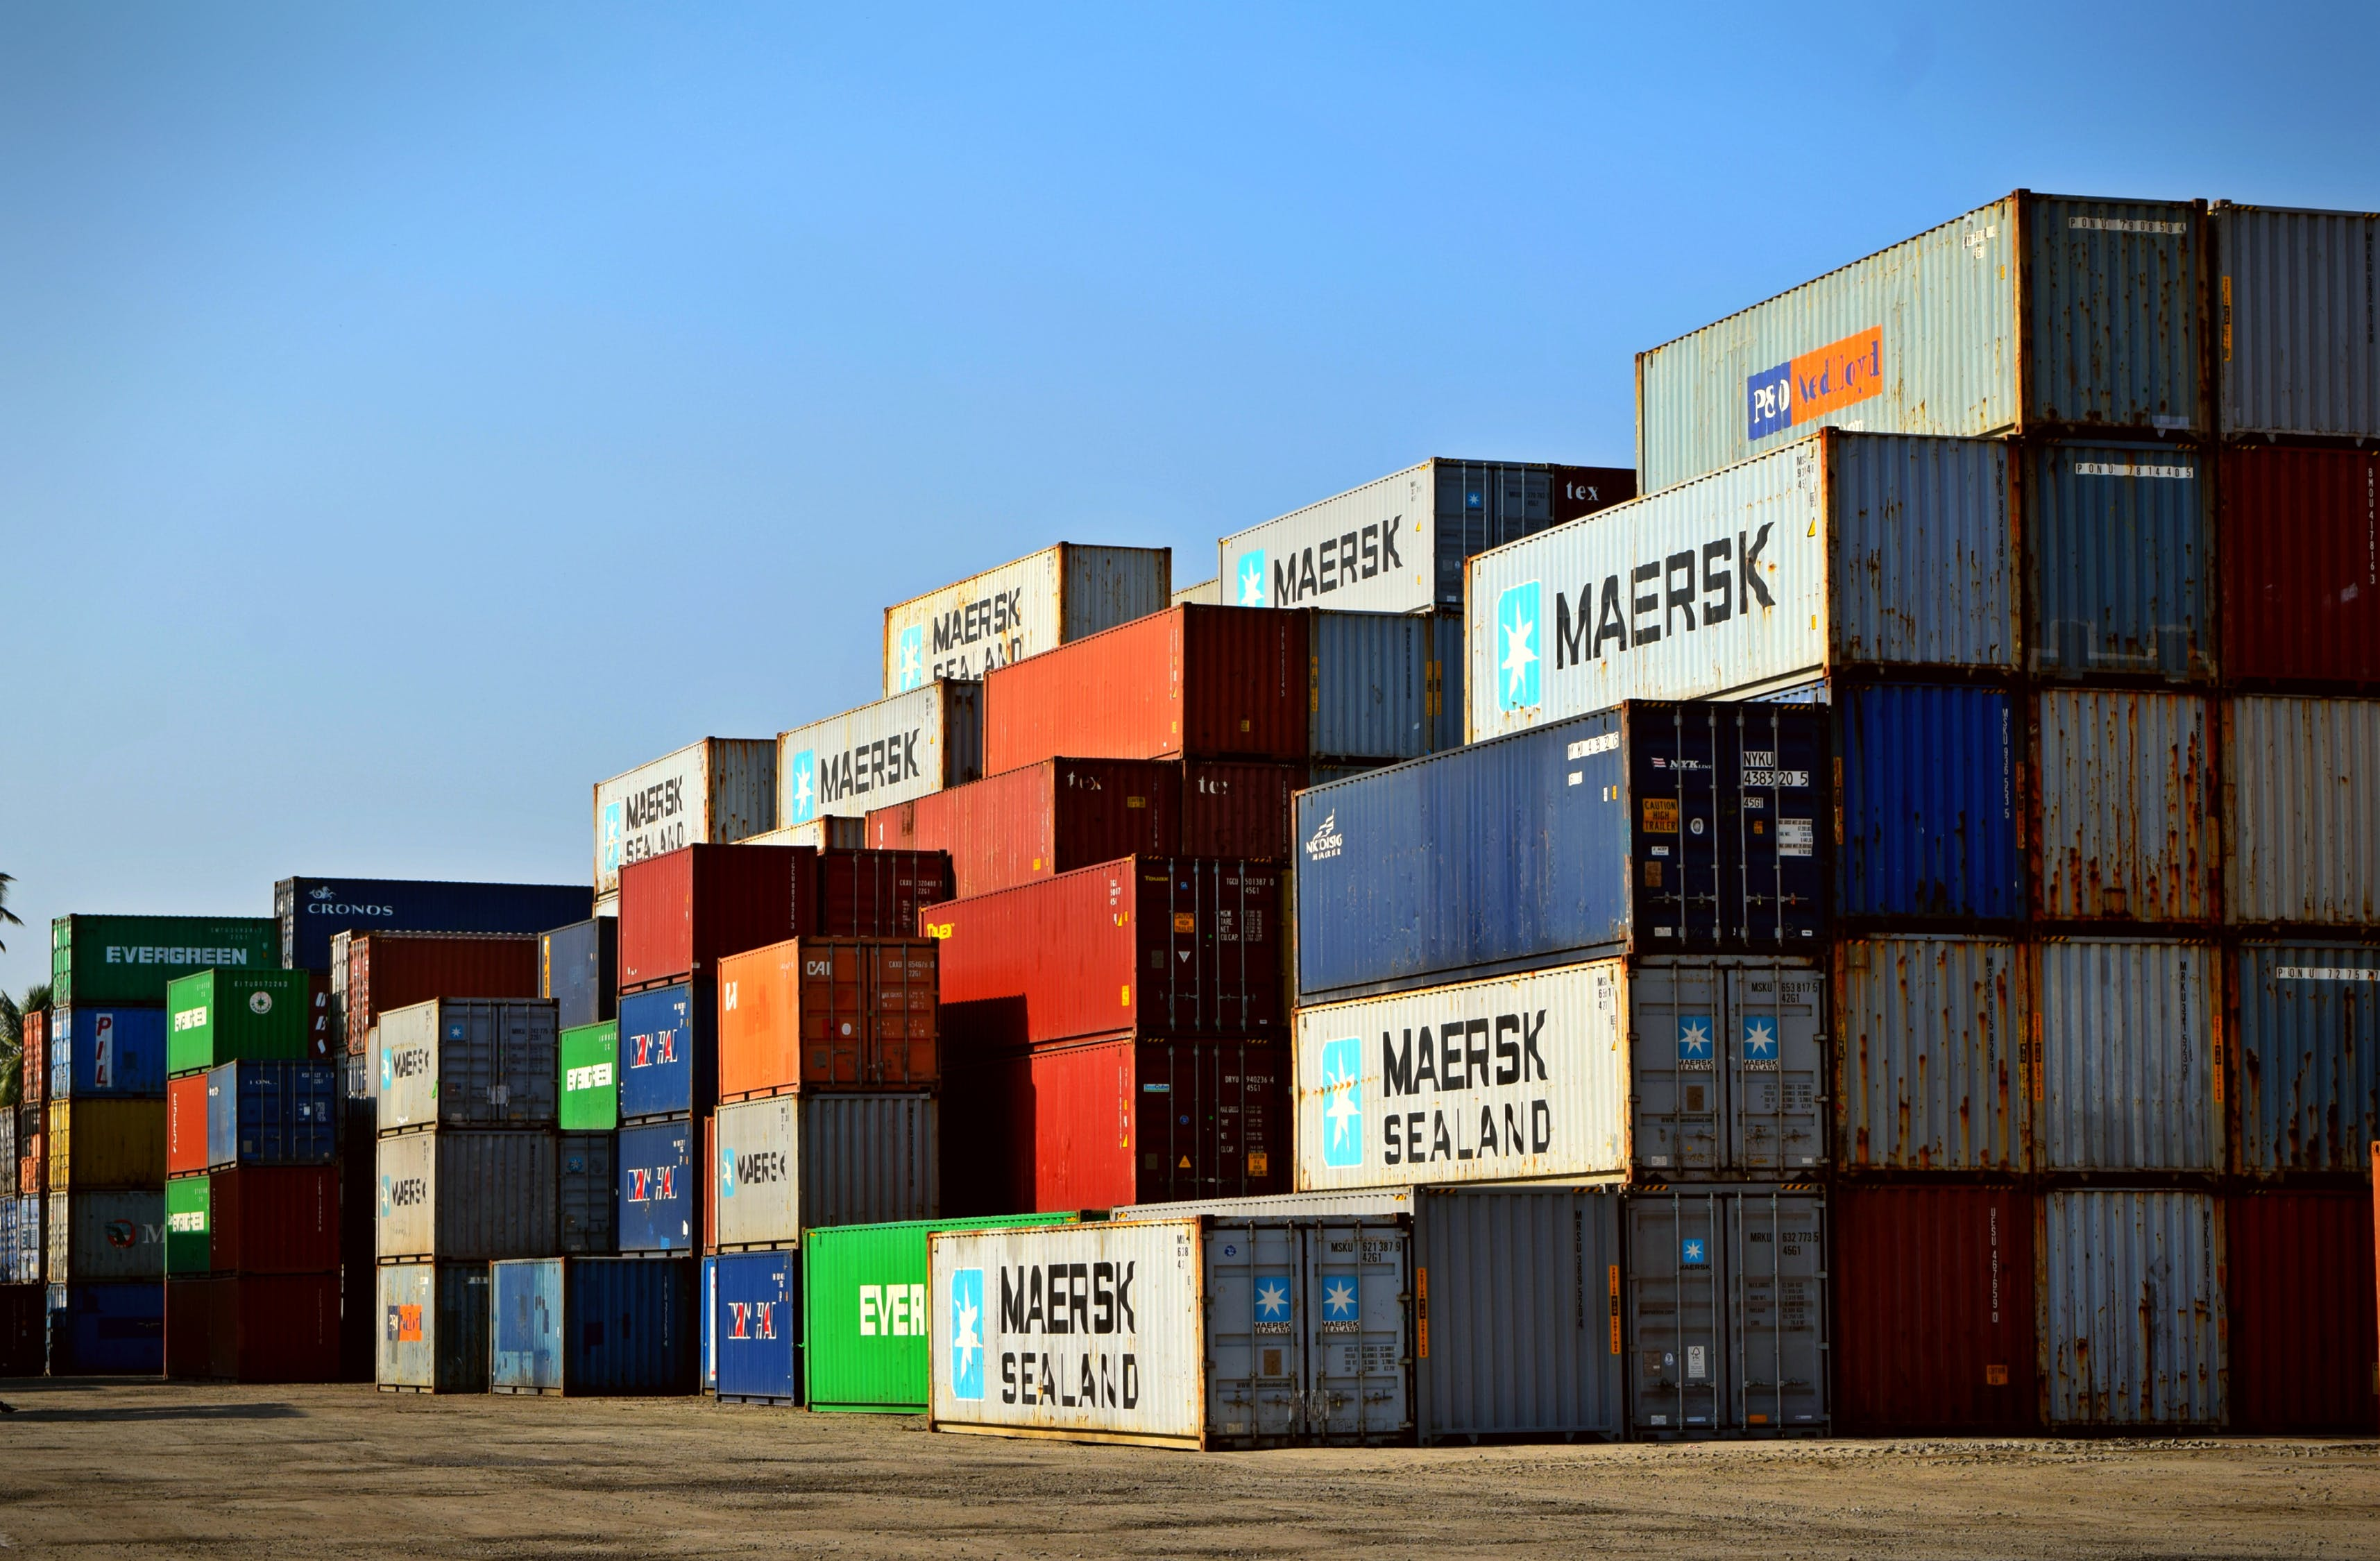

In [1]:
from IPython.display import Image
Image(filename='images/docker.jpeg') 

## Abstract

Machine learning pipelines can be complex, requiring several libraries and tools to get going. Environment and dependency management can be a change and hinder reproducibility. Recent developments in several machine learning tools have made it possible to setup a clean development GPU enabled pipeline with Docker, Jupyter and VS Code.

## Motivation
Newcomers into machine learning can be overwhelmed by the setup required to even get started. Between drivers, libraries and tools, several pieces of software have to work together to get a machine learning environment setup. Cloud based machine learning providers such as Paperspace Gradient and FloydHub do solve some of these issues but create their own. In addition to being significantly more expensive to run for the same amount compute power, using cloud based providers add an extra layer of complexity required in start and stopping machines, reinstalling libraries, rerunning preprocessing scripts and reloading state. Additionally, while cloud based providers such as Paperspace and FloyHub provide Jupyter notebooks, their application development support (that is, turining your experiements into useful code and tools) are lacking compared to usability of local development. Most cloud providers run their stack via Docker, which can be setup locally and additionally tied with some extra quality of life tools to streamline not only the research process but also the development process.

## The Stack

This development environment will be centered around three key tools: Docker, Jupyter and VS Code. 

1. Ubuntu + NVIDIA driver + Docker + nvidia-container-toolkit
1. Jupyter + pyTorch/Tensorflow + Tensorboard
1. VS Code + Remote Development extension

Docker recently added support for GPU passthrough such that only the host requires the NVIDIA driver - all other NVIDIA related dependencies such as cuDNN, etc. are installed in the container, allowing for a very lightweight setup where the host has to do as little as possible. Jupyter is the standard tool for machine learning. In addition, this guide will setup Tensorflow and PyTorch 1.2+, along with Tensorboard, which PyTorch [added official support for](https://pytorch.org/docs/stable/tensorboard.html). VS Code with Container Development will allow us to write conventional code in a GPU enabled container. This can be used for things such as OpenAI's Spinning Up course, which we'll setup below. 

Finally, we'll merge all of these steps together into a single workflow, allowing one locally running Docker container to serve us PyTorch, Tensorboard and GPU which we can connect to using VS Code. 

## Step 0 - Hardware Selection

The computer you use will need an NVIDIA GPU and an Intel CPU is recommended. For a desktop, get a computer that has onboard video and plug in your monitor to the onboard video only. We want the GPU for matrix calculations only so we'll avoid putting anything else on it. This isn't possible on a laptop so there may be additional steps required to get video output (see below).

## Step 1 - OS Installation and Setup

### Installation

Linux is required - Windows does have a variety of options for Docker support but none of them can forward the GPU to the container. This guide will use Ubuntu but this should be portable to other distros as well. Installing Ubuntu is generally straight forward, just follow the prompts. 

**Laptops**: On laptops, you may experience crashes, blank screens or non responsiveness during the installation process. This is due to driver issues (Ubuntu uses the open source nouveau driver which is lacking compared to NVIDIA's closed source drivers). The solution is to first test the installer by booting into the live disk mode and installing from there. If you have issues, boot the installer in "safe mode" and then install. After the installation, for the first boot, boot into the OS in safe mode once again and follow the instructions below to install the NVIDIA drivers.

### NVIDIA Drivers

After installation, the next step is to install the NVIDIA drivers. Once installed, your system will become stable and functional and will no longer require safe mode. Open up `Software & Updates`, then click over to the `Additional Drivers` tab, select `Using NVIDIA driver metapackage from nvidia-driver-xxx (proprietary, tested)` and hit apply. After the installation, reboot.

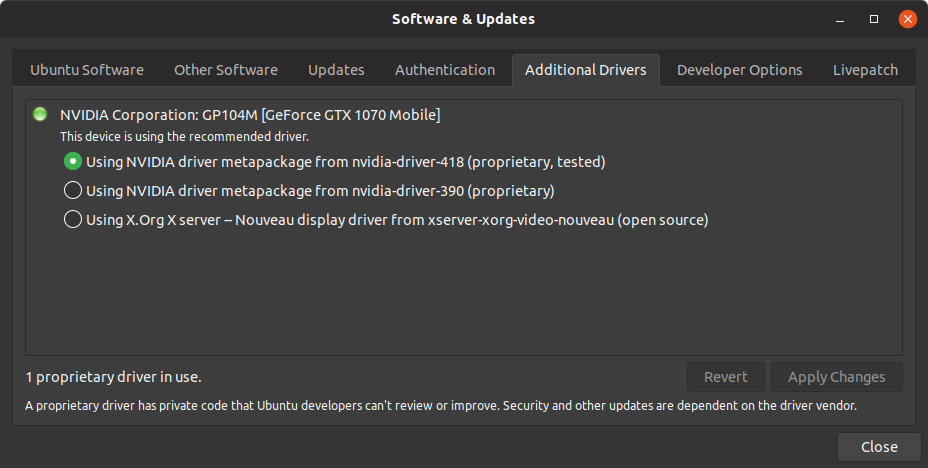

In [2]:
#image-show-output
Image(filename='images/drivers.png') 

### Switchable Graphics

On a laptop, you will want to switch to using the onboard GPU only to avoid draining your battery. Open up the NVIDIA control panel and select the `Power Saving Mode`. The NVIDIA GPU will still work fine but will only be powered up when being used. 

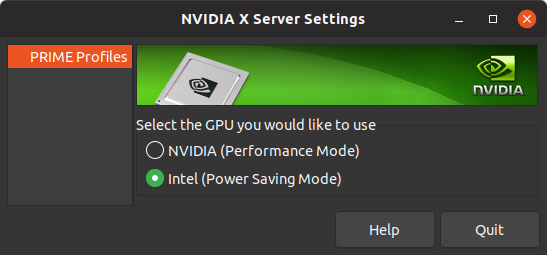

In [3]:
#image-show-output
Image(filename='images/nvidia.png') 

## Step 2 - Install Docker and nvidia-container-toolkit

This step is straightforward - install Docker, then follow Docker next steps to add user to docker group, then install nvidia-container-toolkit following the instruction on the pages below.

1. https://docs.docker.com/install/linux/docker-ce/ubuntu/
1. https://docs.docker.com/install/linux/linux-postinstall/
1. https://github.com/NVIDIA/nvidia-docker

**Note**: if you are using Ubuntu 19.04, you'll need to modify the distribution variable of nvidia-docker script to say ubuntu18.04 as 19.04 binaries aren't available. 18.04 binaries appear to be forward compatible and I have not had any issues with them.

### Install Verification

Now is a good time to quickly verify the installation. Here are some quick commands to verify that the containers are working correctly. If this all checks out, you are now setup do use GPU in Docker containers. 

- Tensorflow: https://www.tensorflow.org/install/docker
- PyTorch: https://hub.docker.com/r/pytorch/pytorch/

#### TensorFlow

In [4]:
#code-show-output
print(open('test-tensorflow.sh').read())

docker run -it --rm \
---gpus all --shm-size 16G \
tensorflow/tensorflow:latest-gpu \
python -c "import tensorflow as tf; print(tf.test.is_gpu_available())"


#### PyTorch

In [5]:
#code-show-output
print(open('test-pytorch.sh').read())

docker run -it --rm \
--gpus all --shm-size 16G \
pytorch/pytorch \
python -c "import torch; print(torch.cuda.is_available())"


**Note**: the magic happens with `--gpus all` which tells Docker to pass all GPUs to the container. Additionally, `--shm-size 16G` is used to pass access to all RAM (16G on my host) to the container as AI workloads use a lot of RAM.

## Step 4 - Setup Jupyter

Setting up Jupyter is as simple as running Jupyter in a container. You can use one of the many [official Jupyter provided images](https://jupyter-docker-stacks.readthedocs.io/en/latest/). Further below we will discuss building a custom Dockerfile which has the all the various dependencies that you may care about. 

```
docker run --rm \
-u 1000 \
-p 8888:8888 \
-e JUPYTER_ENABLE_LAB=yes \
-v "$PWD":/home/jovyan/work \
--gpus all \ 
--shm-size 16G \ 
jupyter/datascience-notebook
```

## Step 5 - Setup VS Code

### Install VS Code
Install Visual Studio Code using Snap for the cleanest and simplest install: `sudo snap install code --classic`

### Install VS Code Remote Extension
Install the Remote Development Extension Pack in VS Code using `ext install ms-vscode-remote.vscode-remote-extensionpack`

### Setup VS Code for Development Containers
VS Code is now ready for working in containers. We'll setup an example container using the OpenAI Spinning Up code.

1. `git clone https://github.com/openai/spinningup.git`
1. In VS Code, `File -> Open Folder > spinningup`
1. Open up `setup.py` and modify it to use the GPU by changing line 29 from `tensorflow` to `tensorflow-gpu`
1. Create a Dockerfile at the root (see below) (note this Dockerfile is for Tensorflow/Spinning up specifically)
1. On the bottom left, click the two arrows, then select `Add Development Container Configuration Files`, then select `From Dockerfile`
1. Modify `.devcontainer.json` to use the GPU and forward X (see below)
1. Click the arrows once again and select `Reopen in Container`

In [6]:
#code-output
print(open("Dockerfile.spinningup").read())

FROM tensorflow/tensorflow:latest-gpu 

ENV DEBIAN_FRONTEND=noninteractive
RUN apt-get update && apt-get install libopenmpi-dev python3-pip python-opengl python3-tk ssh sudo -y

ARG USERNAME=tf-docker
ARG USER_UID=1000
ARG USER_GID=$USER_UID
RUN groupadd --gid $USER_GID $USERNAME \
    && useradd --uid $USER_UID --gid $USER_GID -m $USERNAME \
    && echo $USERNAME ALL=\(root\) NOPASSWD:ALL > /etc/sudoers.d/$USERNAME \
    && chmod 0440 /etc/sudoers.d/$USERNAME

USER $USERNAME
ENV HOME /home/$USERNAME



In [8]:
#code-output
print(open("devcontainer.json.spinningup").read())

{
    "context": "..",
    "dockerFile": "../Dockerfile",
    "extensions": [],
    "runArgs": 
    [
        "-u", "1000:1000",
        "--gpus", "all",
        "--shm-size", "16G",
        "-e", "DISPLAY=:0", //for graphical output
        "-v", "/tmp/.X11-unix:/tmp/.X11-unix" //for graphical output
    ],
    "settings": 
    { 
        "terminal.integrated.shell.linux": "/bin/bash"
    },
    
    "postCreateCommand": "pip3 install -e ."
}



You will now be in a Docker container with you code mounted inside with the correct user permissions. To test, open up the terminal and run the following commands from OpenAI.

```
python3 -m spinup.run ppo --hid "[32,32]" --env LunarLander-v2 --exp_name installtest --gamma 0.999
python3 -m spinup.run test_policy data/installtest/installtest_s0
python3 -m spinup.run plot data/installtest/installtest_s0
```

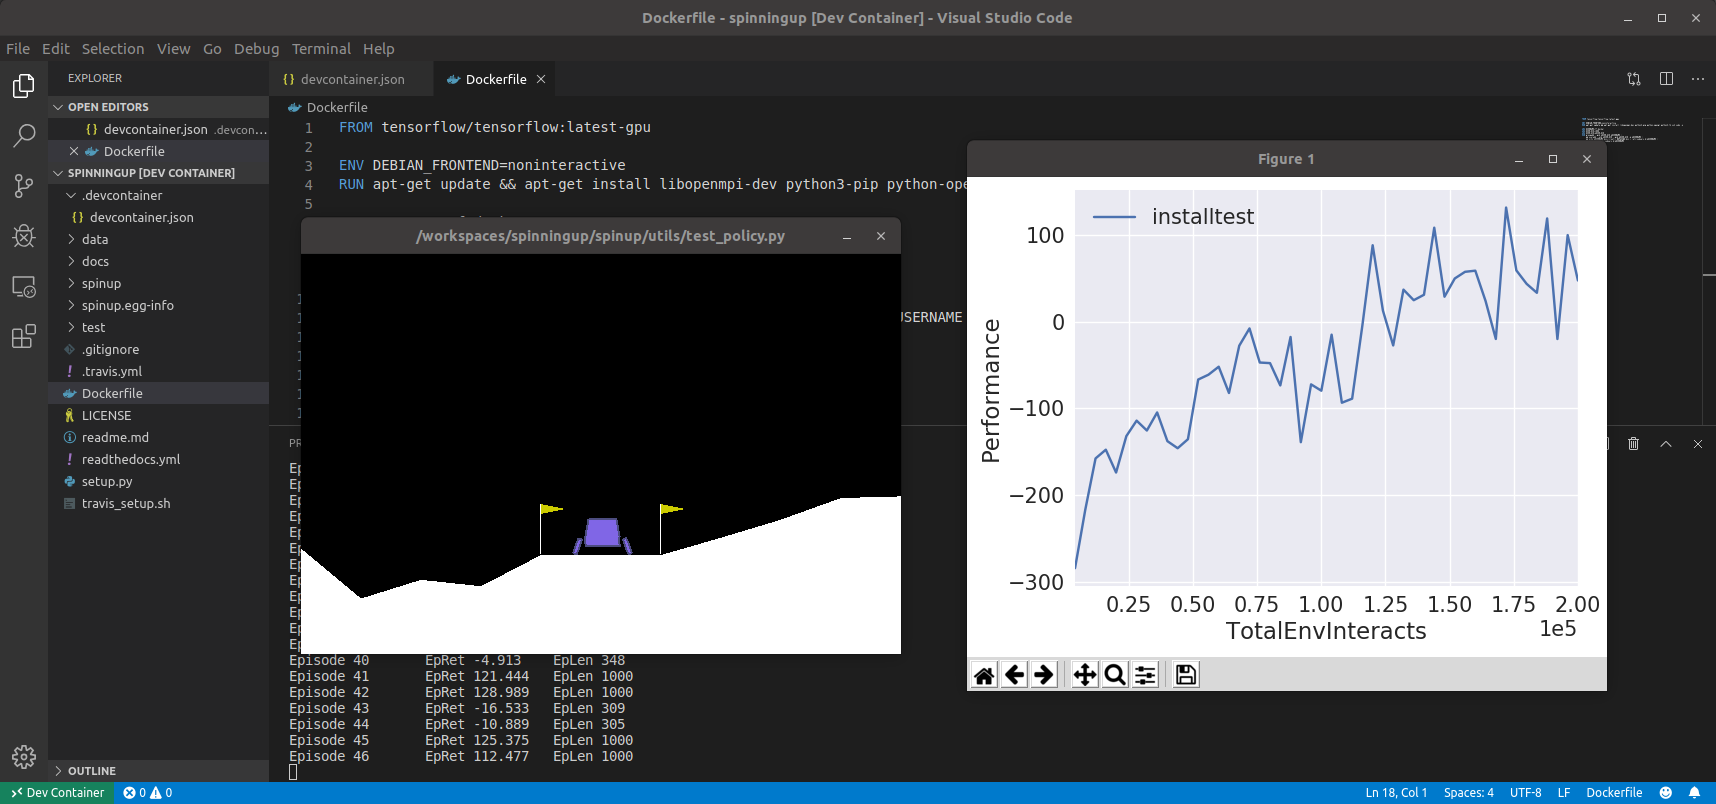

In [9]:
#image-show-output
Image(filename='images/spinningup.png') 

**VS Code Notes:**
1. VS Code gives you a shell inside the container and allows you to install dependencies manually (i.e. apt-get or pip). These changes will not be persisted so while it's fine for testing, always move your changes into your Dockerfile.
1. VS Code saves the container after being built so that it can be reused in future. While this is helpful, it doesn't always update from changes made to the Dockerfile or the .devcontainer.json. To force it to do so, click over the the Docker tab in VS Code and right click > delete the container and then reopen the workspace in the container, causing it to be rebuilt.

## Step 6 - Bringing It All Together

While it is appropriate to setup a seperate dev container instance for every project, it is convenient to have a "master" instance for experimentation. The final is to setup a this machine learning environment which merges all the above steps into one workflow. 

Step one is to build the image you intend to use. In this case, we will setup a Dockerfile intended for machine learning and application development with FastAI and OpenCV, along with PyTorch and Tensorboard, as well as a handful of apt packages. On your host, run the build command against the Dockefile as a named image: `docker build -t <my-image>`

In [10]:
#code-show-output
print(open('Dockerfile').read())

#currently using older base: https://hub.docker.com/r/pytorch/pytorch/
#alternatively, build from cuda/conda base: https://github.com/pytorch/pytorch/blob/master/docker/pytorch/Dockerfile
FROM pytorch/pytorch

#sudo for vscode + jupyter, python-opengl for opencv
RUN apt update && apt install sudo python-opengl -y 

#install latest, update
RUN conda install conda
RUN conda update --all

#pytorch: https://pytorch.org/get-started/locally/
RUN conda install pytorch torchvision cudatoolkit=10.0 -c pytorch

#fastai: https://github.com/fastai/fastai/blob/master/README.md#installation
RUN conda install -c fastai fastai

#jupyter: https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html
#fastai/extensions: https://docs.fast.ai/install.html
RUN conda install -c conda-forge jupyterlab
RUN conda install -c conda-forge jupyter_contrib_nbextensions

#tensorboard
RUN conda install -c conda-forge tensorboard
RUN pip install future
RUN pip install ipywidgets

#opencv, do last conda

Next following the steps above, open VS Code at the root of your projects directory and add `devcontainer.json` to the root of your projects directory with the relevant commands for your environment. In this case, we will setup webcam sharing (for OpenCV), X and display sharing for GUI applications (like OpenAI Spinning Up), Docker socket sharing for running Docker commands inside the dev container and finally sharing the GPU and RAM. 

In [11]:
#code-show-output
print(open('devcontainer.json').read())

{
	"context": "..",
	"image": "fastai",
	"runArgs": 
	[
		"-u", "1000:1000",
		"--device", "/dev/video0:/dev/video0",
		"-v", "/tmp/.X11-unix:/tmp/.X11-unix",
		"-v","/var/run/docker.sock:/var/run/docker.sock",
		"--group-add", "video",
		"-e", "DISPLAY=:0",
		"--gpus", "all",
		"--shm-size", "16G"
	],
	
	"settings": 
	{ 
		"terminal.integrated.shell.linux": "/bin/bash"
	},
	
	"extensions" : ["ms-azuretools.vscode-docker", "ms-python.python"],
	"appPort": ["8888:8888", "6006:6006"],
	"postCreateCommand": "/bin/bash -c 'jupyter lab --ip=0.0.0.0 --notebook-dir=/workspaces &>/dev/null &'",
	"shutdownAction": "none"
}



Your environment is now setup. Open VS Code at the root of your project and you will be prompted to reopen the folder in a dev container. Doing so will build and launch the dev container and then launch Jupyter as well. The `"shutdownAction": "none"` setting will ensure that even if VS Code is closed, the container will continue running - if you reopen your projects folder in the container, it will simply reconnect to the existing container instead of rebuilding it. Note, on the first launch (or if the container relaunched after being forcibly shutdown), you will need to run `jupyter notebook list` in the VS Code terminal to get the authenciation cookie of Jupyter. You can navigate to http://localhost:8888/ to login using the cookie outputed by the startup script. To startup Tensorboard, open up a console in Jupyter and run `tensorboard --logdir=<dir>` and then navigate to http://localhost:6006 to view the output